In [1]:
%matplotlib inline
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as snb

from scipy.optimize import minimize
from jax import value_and_grad
from jax import hessian
from jax import random

# for plotting
from matplotlib.colors import ListedColormap

# for manipulating images
from PIL import Image

from exercise7 import PCA_dim_reduction
from exercise7 import visualize_utility
from exercise7 import add_colorbar

from jax import config
config.update("jax_enable_x64", True)

# style stuff
snb.set_theme(font_scale=1.25)
snb.set_style('darkgrid')
colors = ['r', 'g', 'b', 'y']


# 02477 Bayesian Machine Learning - Exercise 7

**Overview**

The topic of this exercise is **multi-class classification** and **decision theory**. Probability theory and Bayes' rule tell us how to summarize our knowledge about a parameter or a prediction using probability distributions.  However, often we have to reduce these distributions a single decision, e.g. does the patient have cancer or not, and decision theory tells us how to do that in a principled manner. We will see how the **posterior predictive probabilities** play a key role in making **optimal decisions** and see how the choice of **utility function** affects the resulting decisions. We will also look at how to quantify and represent the predictive uncertainty for multi-class classification and how to investigate the reliability of the posterior predictive probabilities.

Studying **Bayesian linear models** for multi-class classification problems are important for many reasons: 1) a well-designed linear model can be hard to beat if data is not abundant and 2) linear models help us understand the theory and build intuition for more complex models. Finally, 3) the last layer of most deep neural networks for classification is equivalent to a linear model with a categorical likelihood. Hence, when we learn model parameters for the last layer only in a transfer learning setting, we actually fit a linear model for classification.

- Part 1: Bayesian linear models for multi-class classification
- Part 2: Bayesian decision theory for classification
- Part 3: Image classification
- Part 4: Making decisions with a reject option
- Part 5: Model calibration


**Note**: The exercise contains several **discussion questions**, which are questions, where are supposed to actively experiment with the code and/or reason with the equations to arrive at the relevant conclusions. This also means that we won't provide a specific solution for this task. However, you are more than welcome to check your understanding and your conclusions with the TAs. Instead of proving the full description for every discussion question, we simply tag it with: [**Discussion question**] after the question.


Note that the in this exercise, we will need the python packages called **PIL** (for manipulating images) and **autograd** for computing derivatives. 


## Part 1:  Bayesian linear models for multi-class classification


**From binary to multi-class classification**

In week 3, we discussed binary classification using logistic regression models. We used a *Bernoulli likelihood* with the *sigmoid inverse link function* to model the data, i.e. $y_n \sim \text{Ber}(\sigma(f(\mathbf{x}_n)))$ such that $p(y=1|\mathbf{x}, \mathbf{w}) =  \sigma(f(\mathbf{x}_n))$. Due to the binary nature of $y_n$, we used that $p(y=0|\mathbf{x}, \mathbf{w}) = 1 - p(y=1|\mathbf{x}, \mathbf{w}) = 1 - \sigma(f(\mathbf{x}_n))$, and hence, the function $f(\mathbf{x}_n)$ completely specifies the probabilities for both outcomes of $y_n$. 

This week we will work with the natural extension for multi-class classification. Consider a multi-class problem with $K$ classes and let $\mathcal{D} = \left\lbrace (\mathbf{x}_i, y_i) \right\rbrace_{i=1}^N$ denote a dataset, where $\mathbf{x}_i \in \mathbb{R}^M$ and $y_n \in \left\lbrace 1, 2, \dots, K\right\rbrace$ are the input feature and target label, respectively, for the $i$'th example. 

Since the targets are **discrete** and **unordered**, the categorical distribution with the softmax function is a standard choice:

$$\begin{align*}
y_n|\mathbf{f}_n &\sim \text{Categorical}\left[\text{softmax}(\mathbf{f}_n)\right], \tag{1} 
\end{align*}$$

where ${\mathbf{f}_n} \in \mathbb{R}^K$ is $K$-dimensional latent vector. In contrast to binary classification, $\mathbf{f}_n = f(\mathbf{x}_n) \in \mathbb{R}^K$ is now a $K$-dimensional vector. The output of the softmax-function is also a vector, where the elements are given by
$$\begin{align*}
\text{softmax}(\mathbf{f}_n)_i = \frac{\exp(\mathbf{f}_{n,i})}{\sum_{j=1}^K \exp( \mathbf{f}_{n,j})},
\end{align*}$$

where $\mathbf{f}_{n,i}$ denotes the $i$'th element of vector $\mathbf{f}_n$ and the probabilities of the categorical distribution is given by

$$\begin{align*}
\text{Categorical}(y_n = i|\mathbf{f}_n) = \text{softmax}(\mathbf{f}_n)_i.
\end{align*}$$

**Linear models for multi-class classification**

For linear models for multi-class classification, we model each entry in $\mathbf{f}_{n}$ with a separate linear model, i.e.

$$\begin{align*}
\mathbf{f}_{n, i} &= f_i(\mathbf{x}_n) = \mathbf{w}_i^T \phi(\mathbf{x}_n) \quad\text{for}\quad i = 1, \dots, K, \tag{2} 
\end{align*}$$

where $\mathbf{w}_i \in \mathbb{R}^D$ and $\phi(\cdot)$ is a feature expansion such that $\phi(\mathbf{x}_n) \in \mathbb{R}^D$. 
Instead of $\mathbf{f}_{n, i} = \mathbf{w}_i^T \mathbf{x}_n $, we could also have used Gaussian processes or neural networks if desired.

Note that the linear models in eq. (2) is equivalent to

$$\begin{align*}
\mathbf{f}_n = \mathbf{W}\phi(\mathbf{x}_n),
\end{align*}$$

where $\mathbf{W} \in \mathbb{R}^{K \times D}$ and $\mathbf{w}_i \in \mathbb{R}^D$ is the $i$'th row of $\mathbf{W}$. This set-up is equivalent to the last layer of a neural network for multi-class classification.



**The joint distribution**

To complete the Bayesian model, we impose a prior distribution for each $\mathbf{w}_i$. Specially, we impose zero-mean Gaussian prior on each $\mathbf{w}_i$ yielding the following joint distribution:

$$
\begin{align*}
p(\mathbf{y}, \mathbf{W}) = \prod_{n=1}^N p(y_n|\mathbf{W}) \prod_{i=1}^K p(\mathbf{w}_i) = \prod_{n=1}^N \text{Cat}(y_n|\text{Softmax}(\mathbf{W}\phi(\mathbf{x}_n))) \prod_{i=1}^K \mathcal{N}(\mathbf{w}_i|\mathbf{0}, \alpha^{-1}\mathbf{I}).
\end{align*}
$$



**Approximate inference using the Laplace approximation**

We will again resort to the Laplace approximation for inference because the posterior distribution is analytically intractable (why?) and use **Monte Carlo** sampling to estimate the posterior predictive probabilities $p(y^* = k|\mathbf{y}, \mathbf{x}^*)$.

Compared to the Gaussian process set-up from last week, this implementation is fairly straight forward. However, to faciliate the implementation of the Laplace approximation, we will let $\mathbf{w}_{\text{flat}} = \begin{bmatrix} \mathbf{w}_1, \mathbf{w}_2, \dots, \mathbf{w}_K \end{bmatrix} \in \mathbb{R}^{K \cdot D}$ be a *flattened* version of $\mathbf{W} \in \mathbf{R}^{K\times D}$, where $K\cdot D$ is the total number of parameters of the model. We can then define the Laplace approximation to be

$$\begin{align*}
p(\mathbf{w}_{\text{flat}}|\mathbf{y}) \approx q(\mathbf{w}_{\text{flat}}) = \mathcal{N}(\mathbf{w}_{\text{flat}}|\mathbf{m}, \mathbf{S}), 
\end{align*}$$
where $\mathbf{m} \in \mathbb{R}^{K\cdot D}$ and $\mathbf{S} \in \mathbb{R}^{K\cdot D \times K \cdot D}$. From these quantities, we can extract the marginal posterior mean and covariance for each $\mathbf{w}_i$. For exampe, the approximate marginal posterior for $\mathbf{w}_1$ is $p(\mathbf{w}_1|\mathbf{y}) \approx \mathcal{N}(\mathbf{w}_1|\mathbf{m}_1, \mathbf{S}_1)$, where the mean $\mathbf{m}_1 \in \mathbb{R}^D$ for $\mathbf{w}_1$ is given by first $D$ entries in $\mathbf{m}$ and the marginal posterior covariance $\mathbf{S}_1 \in \mathbb{R}^{D \times D}$ is the first $D \times D$-entries in $\mathbf{S}$ and so on and so forth. But note that $\mathbf{S}$ also contains information about the posterior covariance between each pair of weight vectors $\mathbf{w}_i$ and $\mathbf{w}_j$.

In this exercise, we will rely on **JaX** for computing the gradient and Hessian.



**Making predictions**

To make predictions, we approximate the *posterior predictive distribution* using *Monte Carlo estimation*. 

$$\begin{align*}
p(y^* = k|\mathbf{y}, \mathbf{x}^*) \approx \int p(y^* =k| \mathbf{W}) q(\mathbf{W})\text{d}\mathbf{W} \approx \frac{1}{S} \sum_{j=1}^S p(y^* =k| \mathbf{W}^{(j)}) \quad\text{for}\quad \mathbf{W}^{(j)} \sim q(\mathbf{W})
\end{align*}$$

 for $j = 1, \dots, S$. To implement this, we simply draw the samples from $\mathbf{w}_{\text{flat}}^{(j)} \sim \mathcal{N}(\mathbf{w}_{\text{flat}}|\mathbf{m}, \mathbf{S})$ and then reshape each sample into $\mathbf{W}^{(j)} \in \mathbb{R}^{K\times D}$. Note that there also exists an extension of the probit approximation for multi-class classification.


**Note:** In the code we will represent the class labels as integers from $0, 1, \dots, K-1$ rather than from $1, \dots, K$ because Python counts from 0.

We will start with a small toy example with $K = 4$ classes.

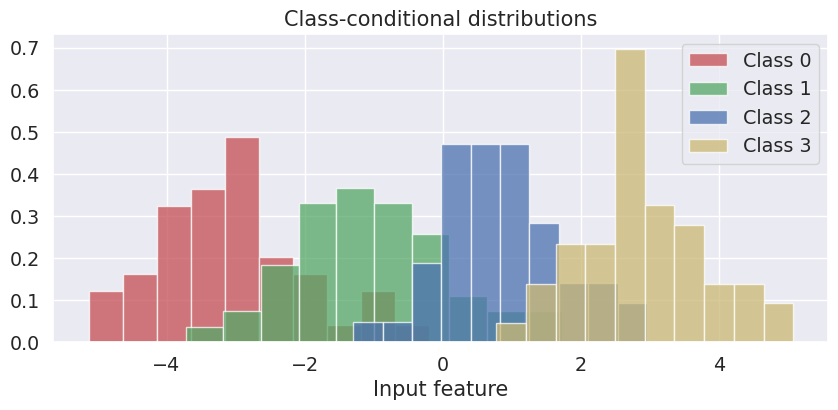

In [2]:
# seed
key = random.PRNGKey(123)
keys = random.split(key, 4)

# number of data points per class
M = 50

# generate simple synthetic toy dataset
xi = [-3 + random.normal(keys[0], shape=(M, 1)),
      -1 + random.normal(keys[1], shape=(M, 1)),
       1 + random.normal(keys[2], shape=(M, 1)),
       3 + random.normal(keys[3], shape=(M, 1))]
x = jnp.concatenate(xi)
y = jnp.hstack((jnp.zeros(M), jnp.ones(M), 2*jnp.ones(M), 3*jnp.ones(M)))
num_classes = 4

# specify input points for predictions
xstar = jnp.linspace(-6, 6, 300)


fig, ax = plt.subplots(1,1, figsize=(10, 4))
for i in range(4):
    ax.hist(xi[i].ravel(), density=True, label='Class %d' % i, alpha=0.75, color = colors[i]);
ax.set(xlabel='Input feature', title='Class-conditional distributions')
ax.legend();


**Implementation**

**Task 1.1**: Complete the implementation of the `log_prior` and `log_likelihood` functions below.

*Hints:**
- *All the parameters of the model are i.i.d. as $\mathcal{N}(0, \alpha^{-1})$ under the prior distribution.*
- *The class variable `y_onehot` contains a onehot-representations of $\mathbf{y}$. Since we rely on JaX and autograd to compute the gradients and Hessian, you can only use `jax.numpy` functions in your implementation.* 

**Task 1.2**: Complete the implementation of `predict_y` below

*Hints:*
-  *Generate the desired number of samples from $\mathbf{w}^{(j)}_{\text{flat}} \sim \mathcal{N}(\mathbf{m}, \mathbf{S})$ and then reshape each sample to $K \times D$ weight matrix, e.g. $\mathbf{W}^{(j)} \in \mathbb{R}^{K \times D}$, and then perform the Monte Carlo estimation.*
- *If you want to check your implementation of the previous task before attempting this one, you can comment out the lines `phat = ...` and `axes[2].plot(xstar, phat...`. If you do so, you should see a plot of the posterior mean of the $K$ linear models.*

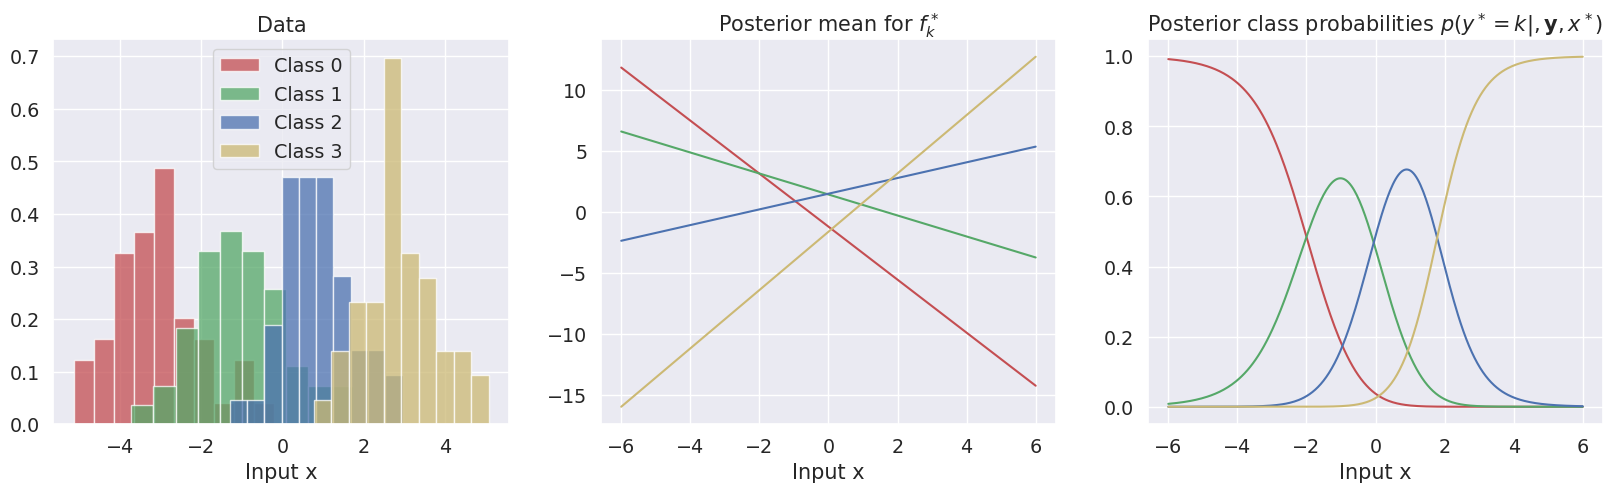

In [3]:
def log_npdf(x, m, v):
    return -0.5*(x-m)**2/v - 0.5*jnp.log(2*jnp.pi*v)

# convert from class label to one-hot encoding
def to_onehot(y, num_classes):
    return jnp.column_stack([1.0*(y==value) for value in jnp.arange(num_classes)])

softmax = lambda x: jnp.exp(x) / jnp.sum(jnp.exp(x), axis = 1)[:, None]



class BayesianLinearSoftmax(object):
    """ Bayesian linear softmax classifier with i.i.d. Gaussian priors """
    
    def __init__(self, X, y, alpha=1):
        
        # data and prior
        self.X, self.y  = X, y
        self.N, self.D = self.X.shape
        self.alpha = alpha
        
        # num classes, parameters and one-hot encoding
        self.num_classes = len(jnp.unique(y))
        self.num_params = self.num_classes * self.D
        self.y_onehot = to_onehot(self.y, self.num_classes)
        
        # fit
        self.compute_laplace_approximation()


    def log_prior(self, w_flat):
        """ Evaluates the log prior, i.e. log p(W). 
            The function accepts the argument w_flat, which is a flattened version of W, such that the shape of w_flat is (T,), where T = num_classes x D is the total number of parameters.
            The return value of the function must be a scalar.
        """
        log_prior_val = jnp.sum(log_npdf(w_flat, 0, 1/self.alpha))

        # check dimensions and return
        assert log_prior_val.shape == ()
        return log_prior_val
    
    
        
    def log_likelihood(self, w_flat):
        """ Evaluates the log likelihood for dataset (self.X, self.y) using a Categorical distribution with softmax inverse link function
            The function accepts the argument w_flat, which is a flattened version of W, such that the shape of w_flat is (T,), where T = num_classes x D is the total number of parameters.
            The return value of the function must be a scalar.
        """
        
        # reshape from flat vector to matrix of size num_classes by D
        W = w_flat.reshape((self.num_classes, self.D))
        

        ##############################################
        # Your solution goes here
        ##############################################
        f = self.X @ W.T
        s = softmax(f)

        loglik_val = jnp.sum(self.y_onehot * jnp.log(s))
        ##############################################
        # End of solution
        ##############################################

        # check dimensions and return
        assert loglik_val.shape == ()
        return loglik_val
        
    def log_joint(self, w_flat):
        return self.log_prior(w_flat) + self.log_likelihood(w_flat)
    
    def compute_laplace_approximation(self):
        """ computes Laplace approximation of model """

        w_init_flat = jnp.zeros(self.num_params)
        cost_fun = lambda W: -self.log_joint(W)
        result = minimize(value_and_grad(cost_fun), w_init_flat, jac=True)

        if result.success:
            w_MAP = result.x
            self.m_flat = w_MAP[:, None]    
            self.A_flat = hessian(cost_fun)(w_MAP)
            self.S_flat = jnp.linalg.inv(self.A_flat)
            return self.m_flat, self.S_flat
        else:
            print('Warning optimization failed')
            return None, None
    
    def predict_f(self, X_star):
        """ computes the posterior distribution of f_i(x, w) = w_i^T phi(x) for all classes """
        
        # get relevant part for each of the K functions
        m = self.m_flat.reshape((self.num_classes, self.D))
        Si = [self.S_flat[i*self.D:(i+1)*self.D, i*self.D:(i+1)*self.D] for i in range(self.num_classes)]
    
        # compute mean and variance for each function
        mu_f_all_classes = X_star@m.T
        var_f_all_classes = jnp.squeeze(jnp.stack([jnp.diag(X_star@Si[i]@X_star.T) for i in range(self.num_classes)], axis=1))

        return mu_f_all_classes, var_f_all_classes
        
    
    def predict_y(self, X_star, num_samples=500, seed=123):
        """ computes and returns p(y^*=k|y, x^*) using Monte Carlo sampling
         
            Arguments:
            X_star            --         PxD prediction points
            num_samples       --         number of Monte Carlo samples to use
            seed              --         seed for random number generator

            Returns
            p_all             --         Post. pred. probabilities for each point in X_star for each class, must be PxK numpy array, where K is the number of classes
        """

        key = random.PRNGKey(seed)
        ##############################################
        # Your solution goes here
        ##############################################
        ws = random.multivariate_normal(key=key, mean= self.m_flat.ravel() ,  cov = self.S_flat,  shape = num_samples)
        
        W = ws.T.reshape((self.num_classes, self.D, num_samples))
        fs = X_star @ W
       
        # fs = jnp.swapaxes(fs, 0, 2)
        fs = jnp.swapaxes(fs, 0,1)
       
        ps = softmax(fs)
        p_all = ps.mean(axis = 2)

        ##############################################
        # End of solution
        ##############################################
        
        assert p_all.shape == (len(X_star), self.num_classes), f"The shape of p_all was expected to be ({len(X_star)}, {self.num_classes}), but the actual shape was {p_all.shape}. Please check the code"
        return p_all
    

# linear model with intercept and slope
design_matrix = lambda x: jnp.column_stack((jnp.ones(len(x)), x))

# fit model and compute predictions
model = BayesianLinearSoftmax(design_matrix(x), y)
# model.log_likelihood(w_flat=random.normal(keys[0], shape=(model.num_classes * model.D, )))
mu_f, var_f = model.predict_f(design_matrix(xstar))
phat = model.predict_y(design_matrix(xstar))

# plot
fig, axes = plt.subplots(1,3, figsize=(20, 5))
for i in range(4):
    # plot histogram of data
    axes[0].hist(xi[i].ravel(), density=True, label='Class %d' % i, alpha=0.75, color=colors[i]);
    # plot posterior mean of latent function y for each class
    axes[1].plot(xstar, mu_f[:, i], label='i = %d' % i, color=colors[i])    
    # plot posterior class probabilitites
    axes[2].plot(xstar, phat[:, i], label='i = %d' % i, color=colors[i])
    
axes[0].legend()
for i in range(3):
    axes[i].set_xlabel('Input x')
    
axes[0].set_title('Data')
axes[1].set_title('Posterior mean for $f^*_k$')
axes[2].set_title('Posterior class probabilities $p(y^*=k|, \\mathbf{y}, x^*)$');

**Task 1.3**: Study the plots above. Explain the role of the softmax-function in eq. (1) above and use the figures above to explain why the name "softmax" makes sense [**Discussion question**]


**Task 1.4**: Implement and plot the **confidence** and **entropy** for the predictive distributions above for each value of $x$ in the vector `xstar` (similar to the rightmost plot above). Comment on the relation between the confidence and entropy plots and the posterior predictive probabilities.



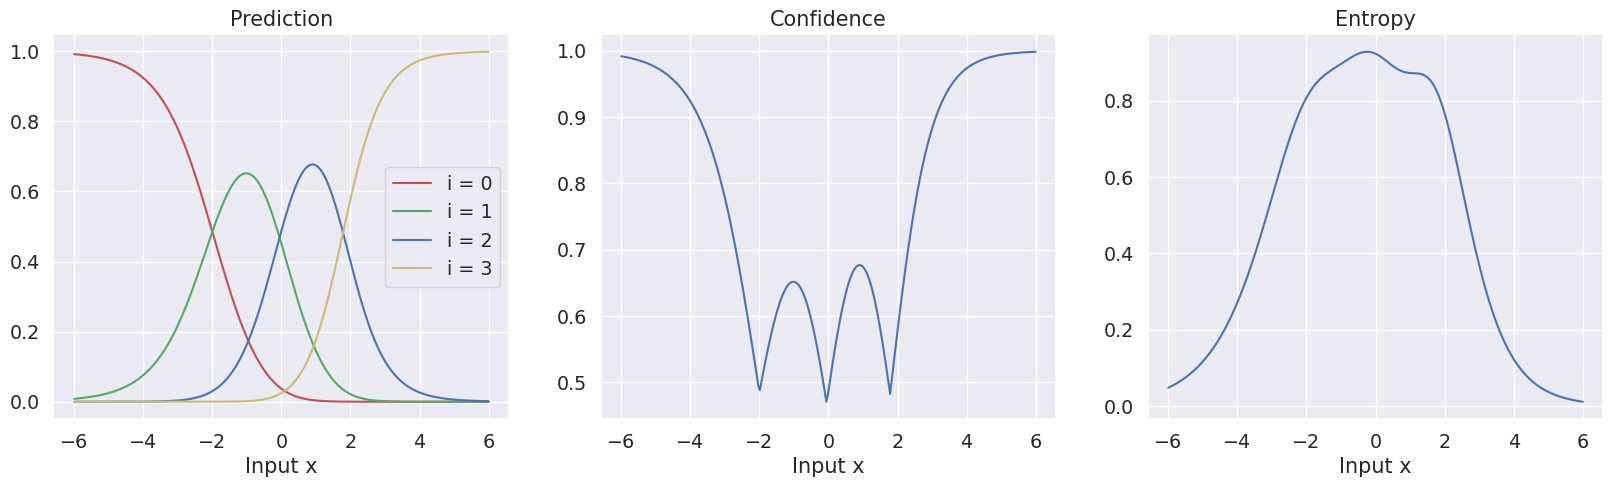

In [4]:
phat = model.predict_y(design_matrix(xstar))
conf = jnp.max(phat, axis = 1)
entropy = - jnp.sum(phat * jnp.log(phat), axis = 1)

fig, axes = plt.subplots(1,3, figsize=(20, 5))
for i in range(4):
    # plot posterior class probabilitites
    axes[0].plot(xstar, phat[:, i], label='i = %d' % i, color=colors[i])
axes[1].plot(xstar, conf)
axes[2].plot(xstar, entropy)
    
axes[0].legend()
for i in range(3):
    axes[i].set_xlabel('Input x')
    
axes[0].set_title('Prediction')
axes[1].set_title('Confidence')
axes[2].set_title('Entropy');


## Part 2:  Bayesian decision theory for classification

Making a decision for multi-class classification entails assigning a class label $\hat{y}^* \in \left\lbrace 1, 2, \dots, K\right\rbrace$ to a new test point $\mathbf{x}^*$. In Bayesian decision theory, the utility function $\mathcal{U}(y^*, \hat{y})$ specifies the **utility** (i.e. gain) for predicting $\hat{y}^*$ when the true target is $y^*$.

In practice, we don't know the true target $y^*$, but the predictive posterior distribution $p(y^*|\mathbf{y}, \mathbf{x}^*)$ contains all the relevant knowledge about $y^*$ given our observed data $\mathbf{y}$. Therefore, we compute the **expected utility** wrt. the posterior predictive distribution for each possible value of $\hat{y}$ and then assign the class label that **maximizes the expected utility**. That is,

\begin{align*}
\hat{y}^* = \arg\max\limits_{k \in \left\lbrace 1, 2, \dots, K\right\rbrace} \mathbb{E}_{p(y^*|\mathbf{y}, \mathbf{x}^*)}\left[\mathcal{U}(y^*, \hat{y}=k)\right]
\end{align*}

Since $p(y^*|\mathbf{y}, \mathbf{x}^*)$ is a discrete probability distribution with probabilities $p(y^* = k|\mathbf{y}, \mathbf{x}^*) = \pi_k$, expectations with respect to $p(y^*|\mathbf{y}, \mathbf{x}^*)$ is simply a weighted sum.

In the videos we saw that in order to make optimal decisions under the **0/1-utility function** (remember utility is just negative loss and vice versa), we simply have to pick the class label with largest posterior probability. Let's investigate this empirically and study how the decision regions change when we change the utility-function.

**Task 2.1**: Complete the implementation of the function `compute_expected_utility`

*Hints: How do we compute expectations with respect to discrete distributions?*

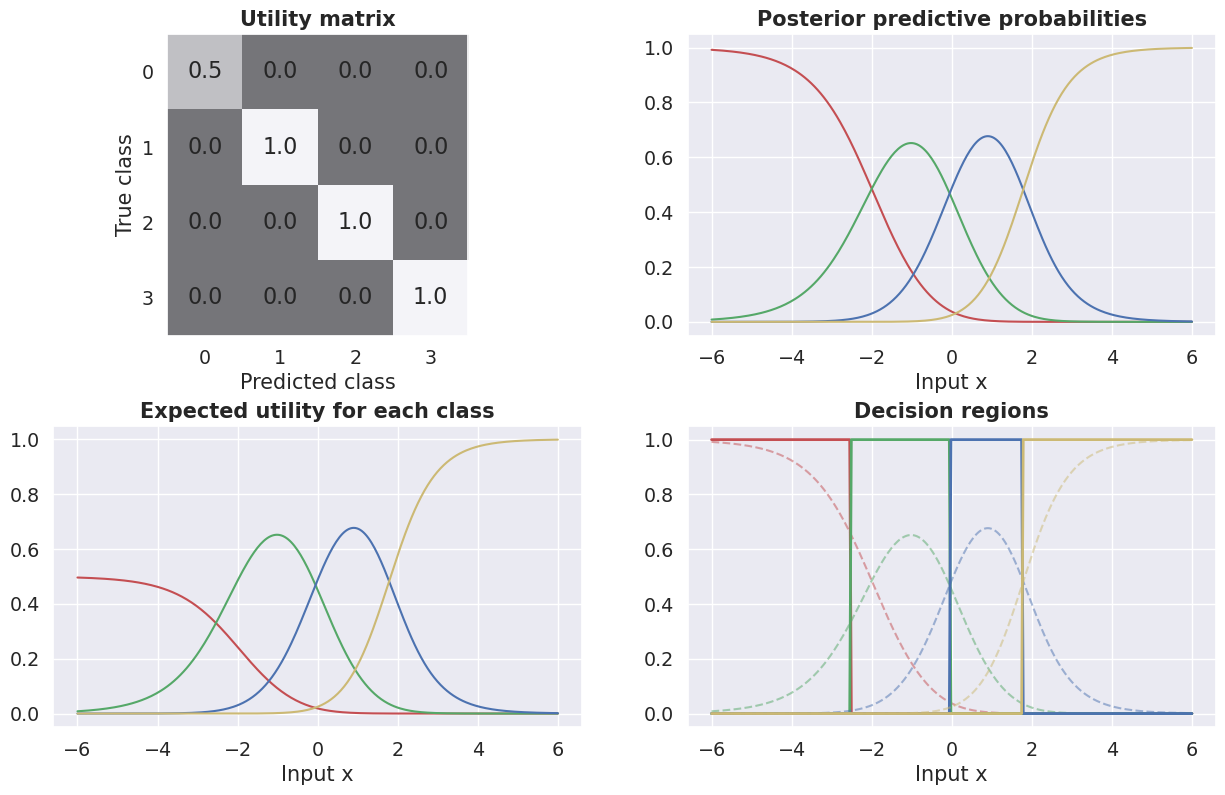

In [5]:
def compute_expected_utility(U, phat):
    """ computes the expected utility for a multi-class classification problem with K classes for utility matrix U and posterior predictive probabilities phat 
        
        Arguments
        U               --      Utility matrix (shape: [K x K])
        phat            --      Posterior predictive probabilities (shape: [P x K]), where P is the number of prediction points

        expected_util   --      Expected utility for each class for each point in phat (shape: P x K)           
           """
    

    expected_util = jnp.zeros_like(phat)
    for y in range(4):
        expected_util = phat @ U

    # check dimensions and return
    assert expected_util.shape == phat.shape, f'The variable expected_util was expected to have shape {phat.shape}, but the actual shape was {expected_util.shape}. Please check your code.'
    return expected_util

# define utility matrix
U = jnp.identity(num_classes)
# U *= 2
U = U.at[0,0].set(0.5)
# U = U.at[3,2].set(0.8)



# compute the expected utility for each class
expected_utility = compute_expected_utility(U, phat) 

# make decisions
decisions = to_onehot(jnp.argmax(expected_utility, axis=1), num_classes)
    
# plot everything
fig, axes = plt.subplots(2, 2, figsize=(15, 9))

# utility matrix
visualize_utility(axes[0,0], U)

# posterior predictive probs
for i in range(num_classes):
    axes[0,1].plot(xstar, phat[:, i], color=colors[i])
axes[0,1].set_title('Posterior predictive probabilities', fontweight='bold')
axes[0,1].set_xlabel('Input x')

# expected utility
for i in range(num_classes):
    axes[1,0].plot(xstar, expected_utility[:, i], color=colors[i]);
axes[1,0].set_title('Expected utility for each class', fontweight='bold')
axes[1, 0].set_xlabel('Input x')

# decisions
for i in range(num_classes):
    axes[1,1].plot(xstar, decisions[:, i], color=colors[i], linewidth=2);
    axes[1,1].plot(xstar, phat[:, i], color=colors[i], alpha=0.5, linestyle='--')
axes[1,1].set_title('Decision regions', fontweight='bold')
axes[1,1].set_xlabel('Input x')

fig.subplots_adjust(hspace=0.3)
    

**Task 2.2**: Use the figure above to explain how Bayesian decision theory works for multi-class classification. [**Discussion question**]

We will just pick the class with the largest utility

**Task 2.3**: What happens to the expected utilities and to the decisions if you scale the utility matrix by a positive constant? [**Discussion question**]

Nothing

**Task 2.4**: What happens to the decision boundary if you introduce a negative utility of $-1$ for predicting 1 (green), when the true target is 0 (red)? What about $-2$? [**Discussion question**]

It becomes much less likely to pick green

**Task 2.5**: What happens if you change the 0/1 utility function to have $U_{23} = U_{32} = 1$? [**Discussion question**]

It just stops predicting yellow, I guess its just not inclined to actually pick it, since it might as well pick blue

**Task 2.6**: What happens if you change the 0/1 utility function to have $U_{11} = 0$? or to $U_{11} = 0.5$? [**Discussion question**]

## Part 3:  Image classification

It's now time to apply the material from part 1 and part 2 to a real dataset. Specifically, we will work with a subset of the Linnaeus 5 dataset (http://chaladze.com/l5/). The original Linnaeus 5 dataset contains images of size 256x256 from 5 classes, but we will work with a subset of this dataset containing a total of 3200 images in 4 classes (dogs, birds, flowers, berries). The images have been resized to 128x128 with the sole purpose of reducing the size of the data file. 

We will use **transfer learning** and use a pretrained ResNet18-network as a **feature extractor** for the images. ResNet18 is a convolutional neural network with 18 layers, which has been trained on a huge image dataset called ImageNet. The ImageNet containes images from 1000 different classes, which means that the very last layer of the ResNet architecture is a softmax-layer with 1000 outputs. However, if we get rid of the very last layer, we can use the rest of the network as a general feature extractor for images. That is, we propagate each image through the network we can use the very last hidden layer as a 512-dimensional feature vector for the image.

The details of how this works beyond what's written above is **not** part of the curriculum of the course and therefore, we have pre-computed feature vectors for all the images for you. 

However, if you are interested in the details, you can look at the following resources:

- Code used for feature extraction [here](https://github.com/christiansafka/img2vec)
- Paper describing the ResNet architecture [here](https://arxiv.org/pdf/1512.03385.pdf)
- A Pytorch tutorial for transfer learning for vision problems [here](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#sphx-glr-beginner-transfer-learning-tutorial-py)


Let's load the data

In [6]:
data = jnp.load('./ex7_data.npz')
labels = list(data['labels'])
targets = data['targets']
num_classes = data['num_classes'][()]

img_train, img_test = data['Xtrain'], data['Xtest']
ytrain, ytest = data['ttrain'], data['ttest']
train_idx = data['train_idx']
test_idx = data['test_idx']

N, D = img_train.shape
Ntest = len(img_test)
print(f'Number of images for training: {N}')
print(f'Number of images for test: {Ntest}')
print(f'Number of features: {D}')
print(f'Number of clases: {num_classes}')


Number of images for training: 320
Number of images for test: 2880
Number of features: 512
Number of clases: 4


.. and plot a few examples

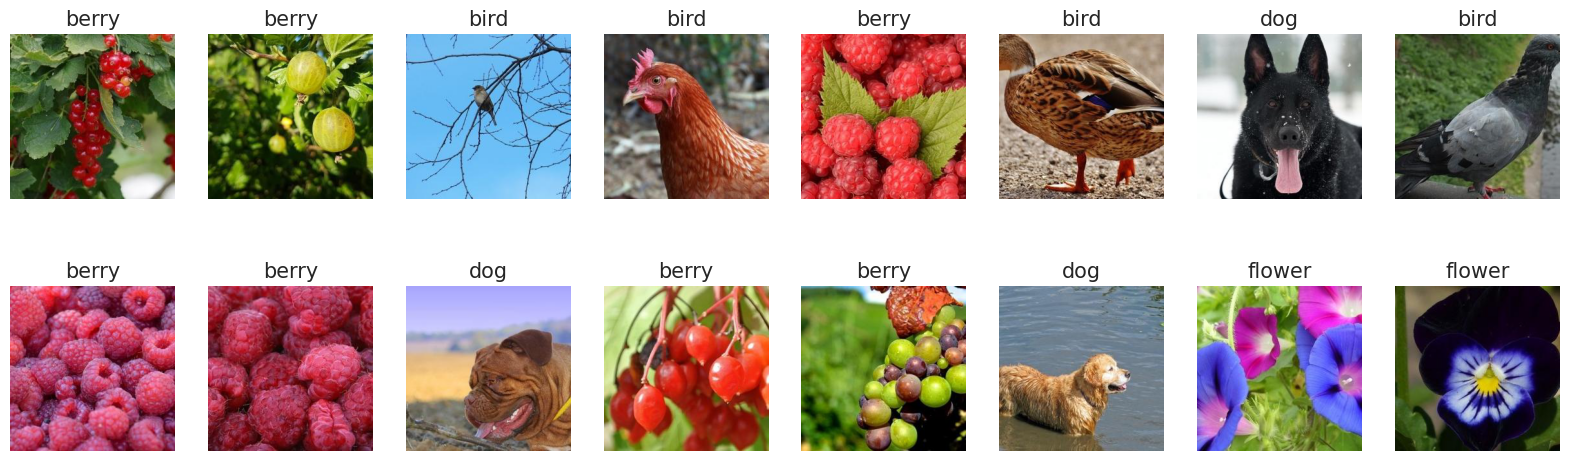

In [7]:
def show_example(ax, i):
    """ show training example i """
    
    j = train_idx[i]
    img = Image.open('./images/%d.jpg' % j)
    target = targets[j]
    ax.imshow(img)
    ax.set_title(labels[int(target)])
    ax.grid(False)
    ax.axis('off')

fig, ax = plt.subplots(2, 8, figsize=(20, 6))
for i in range(16):
    show_example(ax.flat[i], i)

Each image is represented using a 512-dimensional feature vector, but we will (again) reduce the dimensionality to $D = 2$ using principal component analysis (PCA) for the purpose of visualization.

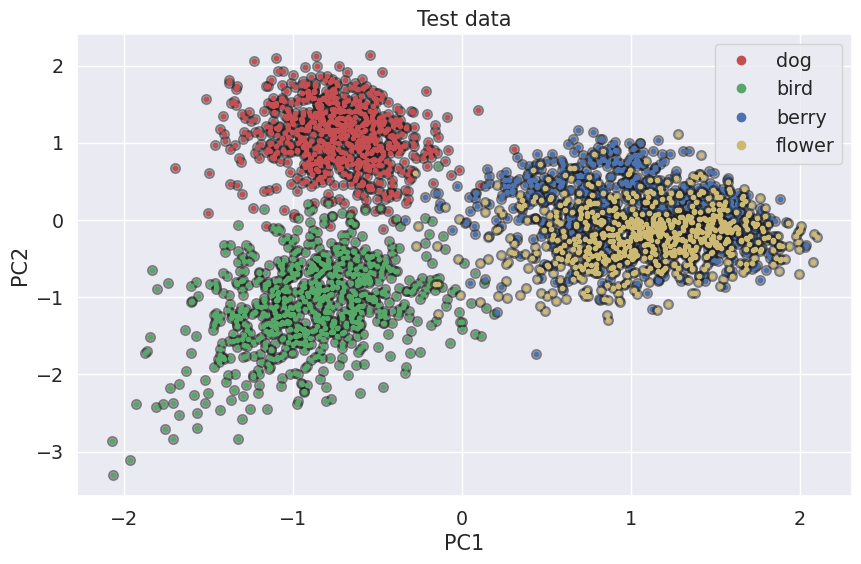

In [8]:
Ztrain, Ztest = PCA_dim_reduction(img_train, img_test, num_components=2)

def plot_pca_data(ax, legend=True, alpha=1):

    for i in range(num_classes):
        ax.plot(Ztest[ytest==i, 0], Ztest[ytest==i, 1], '.', color='k', markersize=14, alpha=0.4)
        ax.plot(Ztest[ytest==i, 0], Ztest[ytest==i, 1], '.', color=colors[i], label=labels[i], markersize=6, alpha=alpha)
    if legend:
        ax.legend(markerscale=2)
    ax.set(xlabel='PC1', ylabel='PC2')
    ax.set_title('Test data')

fig, ax = plt.subplots(figsize=(10, 6))
plot_pca_data(ax);


Let's  fit the model and visualize the posterior class probabilitites.

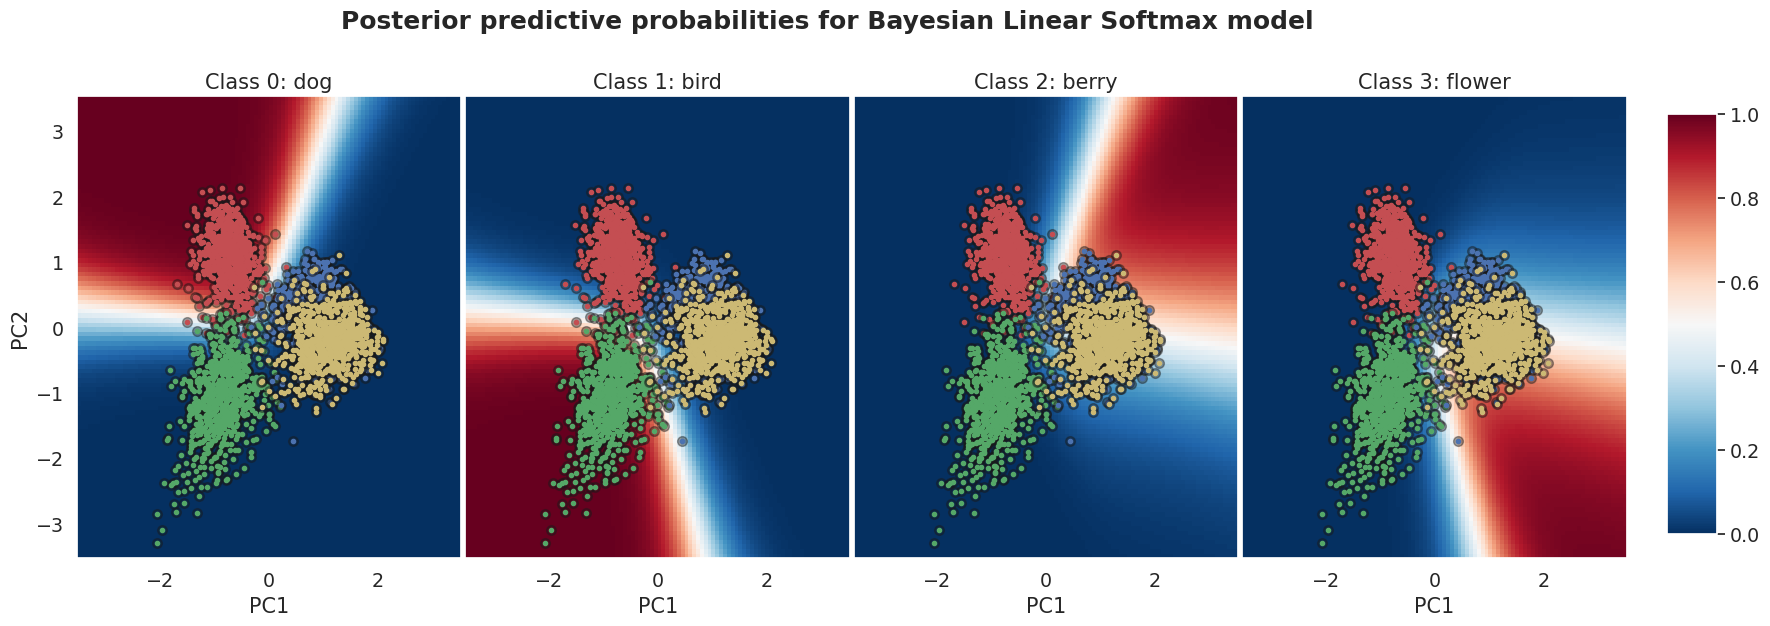

In [9]:
def visualize_regions(x_grid, posterior_class_probs, name, show_data=True):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 6))
    for i in range(num_classes):
        
        probs_reshaped =  posterior_class_probs[:, i].reshape((len(x_grid), len(x_grid)))
        im = axes[i].pcolormesh(x_grid, x_grid,probs_reshaped, cmap=plt.cm.RdBu_r, clim=(0, 1), shading='auto')

        if show_data:
            plot_pca_data(axes[i], legend=False)
        axes[i].set_title('Class %d: %s' % (i, labels[i]))

        if i > 0:
            axes[i].set_yticklabels([])
            axes[i].set_ylabel('')

    fig.subplots_adjust(right=0.9, wspace=0.01)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.025, 0.7])
    fig.colorbar(im, cax=cbar_ax);
    fig.suptitle(name, fontweight='bold', y=1.025)
        
# we want to have an intercept in the model
X_train, X_test = design_matrix(Ztrain), design_matrix(Ztest)
 
# prepare grid for making predictions
x_grid = jnp.linspace(-3.5, 3.5, 100)
XX1, XX2 = jnp.meshgrid(x_grid, x_grid)
Xp = jnp.column_stack((XX1.ravel(), XX2.ravel()))
X_pred = design_matrix(Xp)

# Fit linear classifier
model = BayesianLinearSoftmax(X_train, ytrain)
p_pred = model.predict_y(X_pred)

# visualize the posterior class proabilities for each model
visualize_regions(x_grid, p_pred, 'Posterior predictive probabilities for Bayesian Linear Softmax model')

**Task 3.1**: Compute predictions (wrt. the 0/1-utility function) and compute the accuracy for the training and test set.



In [10]:
U = jnp.identity(4)

p_pred_train = model.predict_y(X_train)
ut = compute_expected_utility(U = U, phat = p_pred_train)

p_pred_test = model.predict_y(X_test)
ut_test = compute_expected_utility(U = U, phat=p_pred_test)

yhat_train = jnp.argmax(ut, axis = 1)
yhat_test = jnp.argmax(ut_test, axis = 1)

print(jnp.mean(yhat_train == ytrain))
print(jnp.mean(yhat_test == ytest))


0.846875
0.8034722


**Task 3.2**: Compute and plot the **entropy** and **confidence** for the predictions in the plot above. In which areas of the input space is this model most uncertain about the class label?

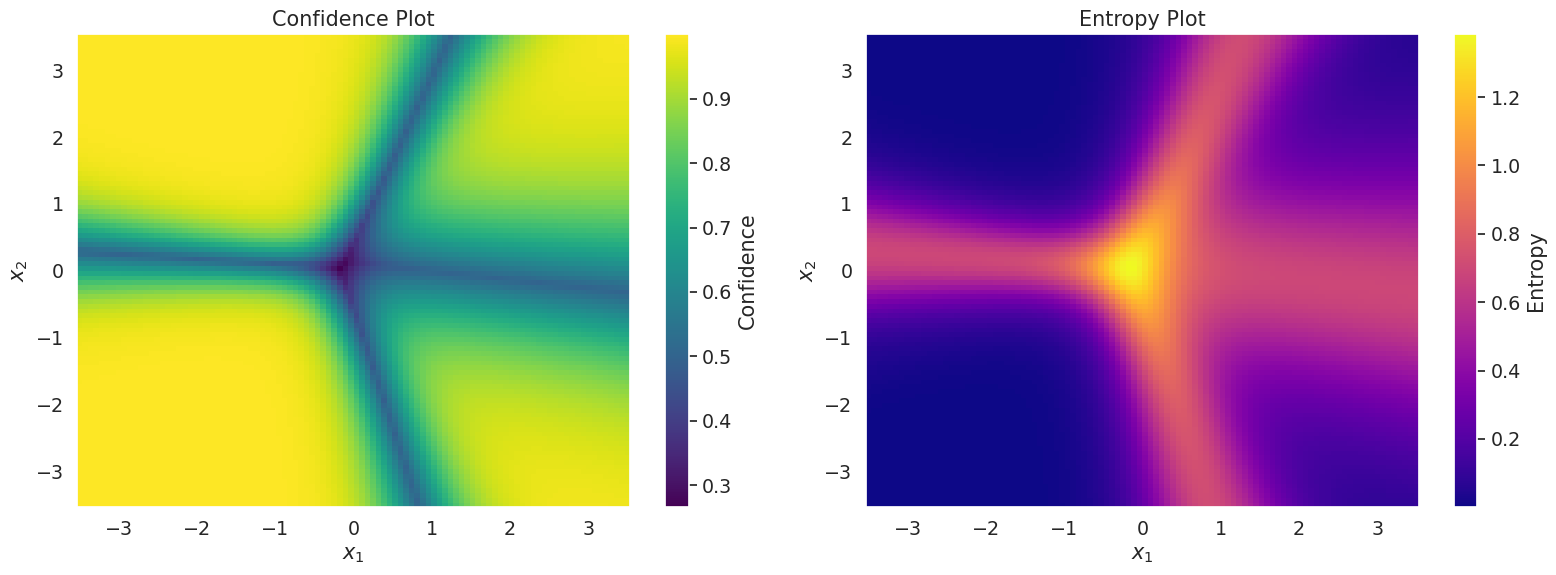

In [11]:
conf = jnp.max(p_pred, 1).reshape(len(x_grid), len(x_grid))
entropy = - jnp.sum(p_pred * jnp.log(p_pred), axis = 1).reshape(len(x_grid), len(x_grid))

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Confidence plot
mesh1 = ax[0].pcolormesh(x_grid, x_grid, conf, cmap='viridis', shading='auto')
cbar1 = fig.colorbar(mesh1, ax=ax[0])
cbar1.set_label('Confidence')
ax[0].set_xlabel('$x_1$')
ax[0].set_ylabel('$x_2$')
ax[0].set_title('Confidence Plot')

# Entropy plot
mesh2 = ax[1].pcolormesh(x_grid, x_grid, entropy, cmap='plasma', shading='auto')
cbar2 = fig.colorbar(mesh2, ax=ax[1])
cbar2.set_label('Entropy')
ax[1].set_xlabel('$x_1$')
ax[1].set_ylabel('$x_2$')
ax[1].set_title('Entropy Plot')

plt.tight_layout()
plt.show()




**Task 3.3**: Compute the average confidence for the training set and test set and accuracy results



In [12]:
conf_train = jnp.max(p_pred_train, 1)
entropy_train = - jnp.sum(p_pred_train * jnp.log(p_pred_train), axis = 1)

conf_test = jnp.max(p_pred_test, 1)
entropy_test = - jnp.sum(p_pred_test * jnp.log(p_pred_test), axis = 1)

print(jnp.mean(conf_train))
print(jnp.mean(conf_test))


print(jnp.mean(entropy_train))
print(jnp.mean(entropy_test))



0.788739387759063
0.758615304275552
0.4621204672156071
0.5133103272411814


## Part 4:  Making decisions with a reject option

Next, we will investigate how to make decisions with a **reject** option, meaning we avoid to making any decisions if the confidence is below a specified threshold $p_{\text{reject}}$.

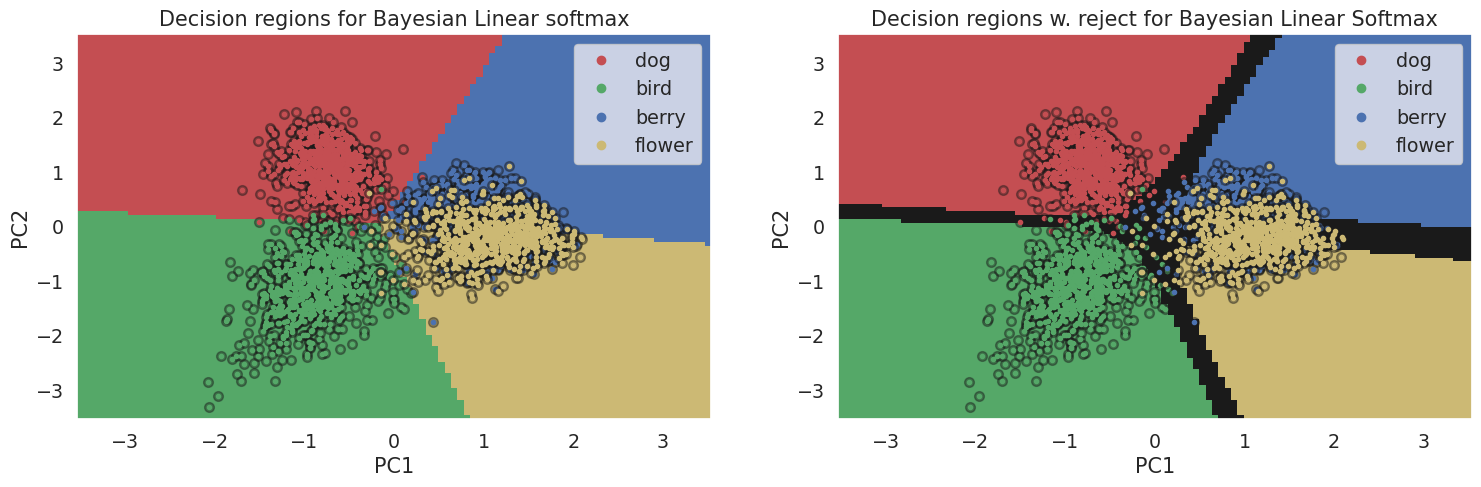

In [13]:
def confidence(x):
    return jnp.max(x, 1)
# specify reject threshold
p_reject = 0.6

# compute decisions under 0/1-utility function and reshape to grid
decisions = jnp.argmax(p_pred, axis=1).reshape((len(x_grid), len(x_grid)))

# identify reject regions
p_pred_confidence = confidence(p_pred) # use the function you implemented earlier
reject_region_bls = 1.0*jnp.logical_not((p_pred_confidence < p_reject).reshape((len(x_grid), len(x_grid))))
decisions_with_reject = (decisions+1)*reject_region_bls

# visualize
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))
plot_pca_data(axes[0])
axes[0].pcolormesh(x_grid, x_grid, decisions, cmap=ListedColormap(colors), alpha=1, shading='auto')
axes[0].set_title('Decision regions for Bayesian Linear softmax')
plot_pca_data(axes[1]);
axes[1].pcolormesh(x_grid, x_grid, decisions_with_reject, cmap=ListedColormap(['k'] + colors), shading='auto')
axes[1].set_title('Decision regions w. reject for Bayesian Linear Softmax');



**Task 4.1**: Explain what you see in the figure above - relate the **reject region** in black to the confidence plot above [**Discussion question**]



**Task 4.2**: What happens to the reject region if you increase or decrease the reject threshold?  [**Discussion question**]


**Task 4.3**: How many percent of the samples in the test set are rejected with $p_{\text{reject}} = 0.6$?



In [14]:

print(jnp.sum(decisions_with_reject == 4.0)  / len(decisions_with_reject)**2)


0.186


**Task 4.4**: What is the test accuracy rate for the samples in the test set, which are not rejected?



In [15]:
U = jnp.identity(4)


p_pred_test = model.predict_y(X_test)

conf = confidence(p_pred_test)
decisions = jnp.argmax(p_pred_test, axis = 1)

reject_region = 1.0*jnp.logical_not((conf < p_reject))

decisions_with_reject = (decisions+1)*reject_region

print(jnp.mean(yhat_test == ytest))

# Accuracy in rejected samples
print(jnp.mean(decisions[decisions_with_reject==4] == ytest[decisions_with_reject==4]) )

0.8034722
0.64285713


**Task 4.5**: If we were to make a decision for the test samples in the reject region, what would the accuracy rate be? 




**Task 4.6**: Instead, if the reject option, implement the following utility function and plot the corresponding decision boundaries:

- Utility of 1 for correctly classifying dogs, birds, and flowers
- Utility of 2 for correctly classifying berries
- Utility of 0 for all misclassifications



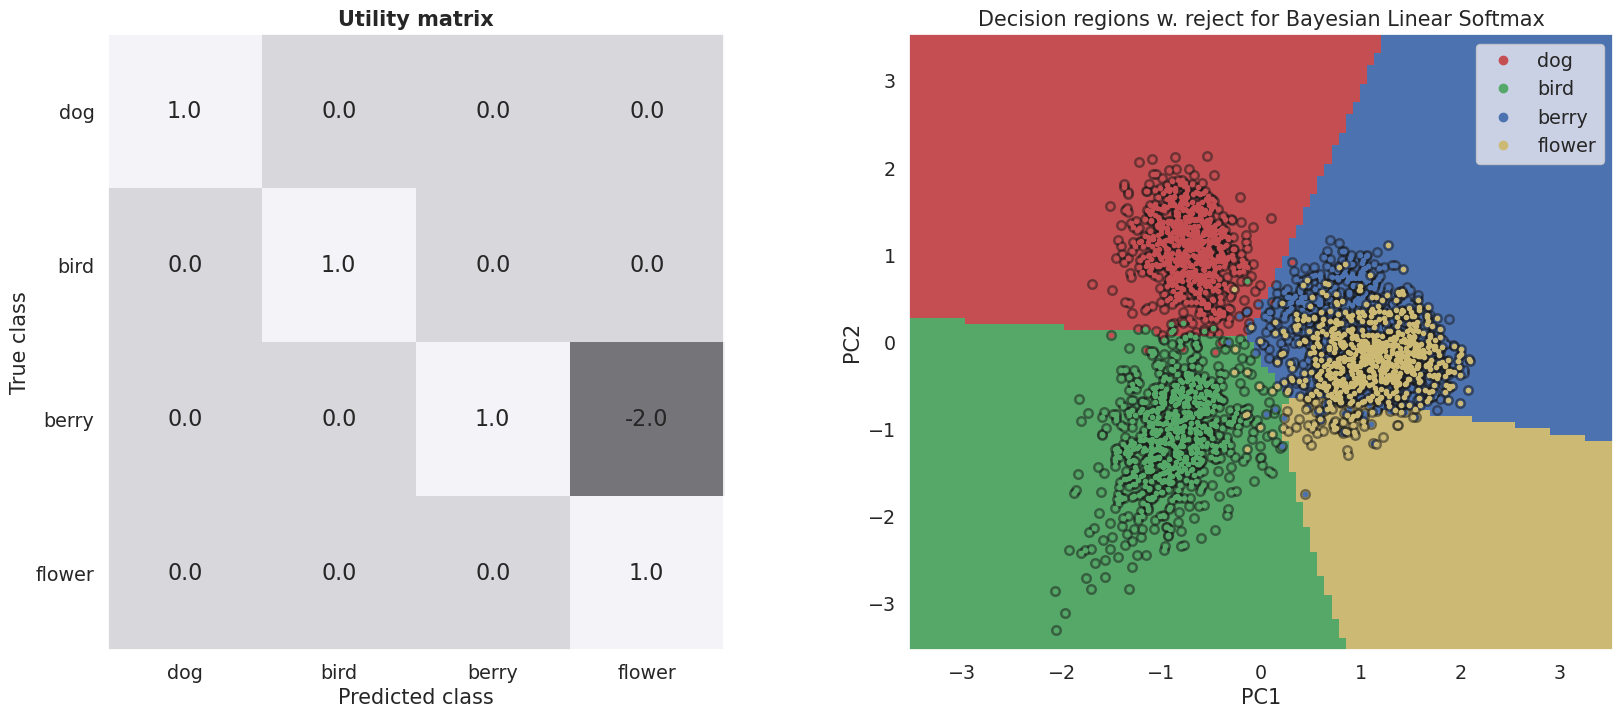

In [16]:
U = jnp.identity(4)
U = U.at[2,3].set(-2)

p_pred = model.predict_y(X_pred)
ut = compute_expected_utility(U = U, phat = p_pred)

yhat = jnp.argmax(ut, axis = 1)
yhat = yhat.reshape((100,100))


# compute decisions under 0/1-utility function and reshape to grid
decisions = jnp.argmax(p_pred, axis=1).reshape((len(x_grid), len(x_grid)))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
visualize_utility(axes[0], U, labels = labels)
plot_pca_data(axes[1]);
axes[1].pcolormesh(x_grid, x_grid, yhat, cmap=ListedColormap(colors), shading='auto')
axes[1].set_title('Decision regions w. reject for Bayesian Linear Softmax');



## Part 5:  Model calibration

As we have seen, the posterior predictive probabilities play a key role in decision-making. In the last part of this exercise, we will study calibration of these probabilities using the **expected calibration error (ECE)**-metric and so-called **reliability plots** (see Section 14.2.2.1 or pages 578 in Murphy2).

In this exercise, we will use the test set $\left\lbrace \mathbf{x}_m^*, y^*_m \right\rbrace_{m=1}^M$ to evaluate these metrics. Let $\hat{y}^*_m = \arg\max_k p(y^*_m = k|\mathbf{y}, \mathbf{x}^*m)$ be the decision (under the 0/1-utility function) for the $m$'th test point and let $\mathcal{C}_m = \max_k p(y^*_m = k|\mathbf{y}, \mathbf{x}^*_m)$ be the corresponding confidence. We will divide the unit interval in $B$ bins and estimate the average accuracy and confidence for each bin:

$$\begin{align*}
\text{acc}(\mathcal{B}_b) &= \frac{1}{|\mathcal{B}_b|} \sum_{m \in \mathcal{B}_b} \mathbb{I}\left(\hat{y}^*_m = y^*_m\right)\\
\text{conf}(\mathcal{B}_b) &= \frac{1}{|\mathcal{B}_b|} \sum_{m \in \mathcal{B}_b} \mathcal{C}_m,
\end{align*}$$

where $\mathcal{B}_b$ contains all the indices of points falling into the $b$'th bin. Then the ECE is defined as

$$\begin{align*}
\text{ECE} = \sum_{b=1}^B \frac{|\mathcal{B}_b|}{M}|\text{acc}(\mathcal{B}_b) - \text{conf}(\mathcal{B}_b)|.
\end{align*}$$

**Note**: The ECE is **not** a so-called *proper scoring rule*, and therefore, we rely solely ECE for model evaluation. In fact, a model can be useless without any predictive power, but still be perfectly calibrated. Therefore, we should always also look at metrics like accuracy, ELPD, log likelihood etc. to make sure the model performs as intended. However, the ECE can be really useful to assess the calibration-aspect specifically.

It is often also useful to plot $\text{acc}(\mathcal{B}_b)$ as a function of $\text{conf}(\mathcal{B}_b)$ for each bin. This is called **reliability plot** or **calibration plot** and may provide insights into whether the model are generally over or underconfident. 


**Task 5.1**: Set $\alpha = 1$. Compute the posterior predictive distribution for the test set of the image classification problem. Compute and plot a histogram of the confidences for each predictions. Repeat for $\alpha=10^{-2}$ and $\alpha=10^2$. How does $\alpha$ generally affect the confidences? Can you explain why?


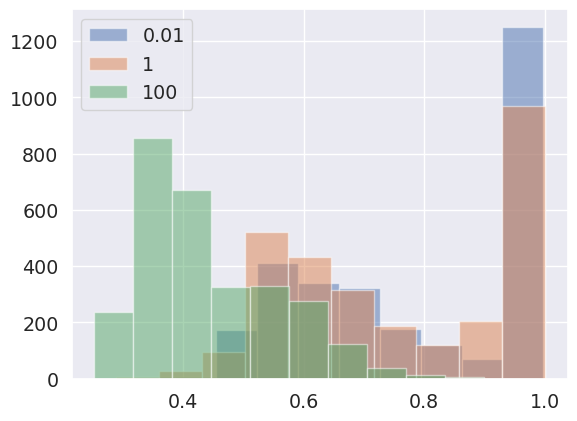

In [17]:

for alpha in [10**-2, 1, 10**2]:

    bls = BayesianLinearSoftmax(X_train, ytrain, alpha = alpha)

    preds = bls.predict_y(X_test)
    confs = confidence(preds)

    plt.hist(confs, alpha = 0.5)
plt.legend(['0.01', '1', '100'])
plt.show()


**Task 5.2**: Implement a function for estimating the expected calibration error (ECE) metric as well as for making a reliability plot. Compute the ECE and the plot reliability for the following values of $\alpha \in \left\lbrace 10^{-2}, 1, 10^2 \right\rbrace$. Compare the reliability plots to the histograms in the previous exercise.




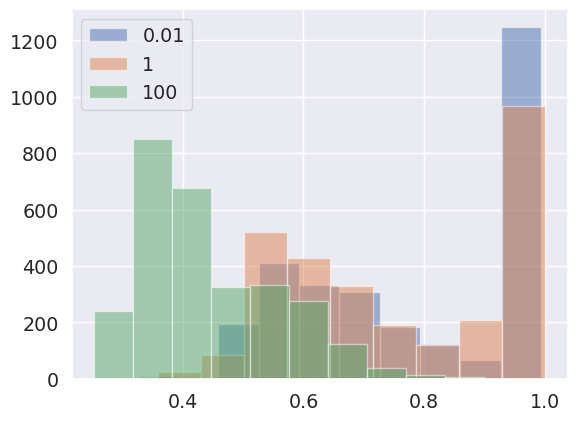

ECE for alpha = 0.01: nan
ECE for alpha = 1: nan
ECE for alpha = 100: nan


In [18]:
eces = [[], [], []]
acc_vec = [[], [], []]
conf_vec = [[], [], []]
nbins = 10
bins = jnp.linspace(0,1, nbins+1)
for i, alpha in enumerate([10**-2, 1, 10**2]):
    bls = BayesianLinearSoftmax(X_train, ytrain, alpha = alpha)
    preds = bls.predict_y(X_test, num_samples= 1000)
    confs = confidence(preds)
    idx = 0
    idx_new = 0

    for j in range(nbins):
        start_bin = bins[j]
        end_bin = bins[j + 1]

        bin_idx = jnp.logical_and(start_bin <= confs, confs <= end_bin)
        beta = jnp.sum(bin_idx)

        

        yhats = jnp.argmax(preds[bin_idx], axis = 1)
        accs = yhats == ytest[bin_idx]

        acc = jnp.sum(accs) / beta
        conf = jnp.sum(confs[bin_idx]) / beta

        acc_vec[i].append(acc)
        conf_vec[i].append(conf)

        eces[i].append(jnp.abs(acc - conf) * beta / len(X_test))

        idx = idx_new

    plt.hist(confs, alpha = 0.5)

eces = jnp.array(eces)
plt.legend(['0.01', '1', '100'])
plt.show()

print(f'ECE for alpha = {10**-2}: {jnp.sum(eces[0])}')
print(f'ECE for alpha = {1}: {jnp.sum(eces[1])}')
print(f'ECE for alpha = {10**2}: {jnp.sum(eces[2])}')

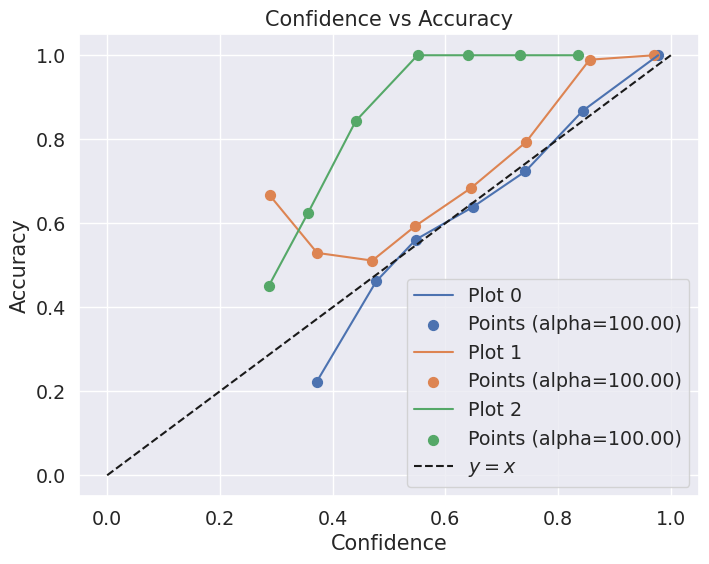

In [19]:
conf_vec = jnp.array(conf_vec)
acc_vec = jnp.array(acc_vec)

# Create a new figure
plt.figure(figsize=(8, 6))

# Plot each confidence vs accuracy line
for i in range(3):
    sorted_indices = jnp.argsort(conf_vec[i])  # Get indices that would sort the confidence array
    sorted_conf = conf_vec[i][sorted_indices]  # Sort confidence values
    sorted_acc = acc_vec[i][sorted_indices]    # Reorder accuracy values based on sorted indices

    plt.plot(sorted_conf, sorted_acc, label=f'Plot {i}')
    plt.scatter(sorted_conf, sorted_acc, s=50, label=f'Points (alpha={alpha:3.2f})')  # Add dots at the points

# Add the y = x line
x = jnp.linspace(0, 1, 100)
plt.plot(x, x, 'k--', label='$y = x$')  # Dotted line for y = x

# Add labels, legend, and title
plt.xlabel('Confidence')
plt.ylabel('Accuracy')
plt.title('Confidence vs Accuracy')
plt.legend()
plt.show()